In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
import threading
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread
import numpy as np
from skimage.color import rgb2yuv
from skimage.feature import canny
from skimage.filters import sobel, median
from skimage.segmentation import slic
import cv2
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn-pastel')

# `SLIC` (Simple Linear Iterative Clustering) 
- `SLIC` is an "oversegmentation" algorithm
- It utilizes `super pixels`; each superpixels contains a group of pixels subject to a certain criteria
- `Super pixels` is a very useful representation of images as it reduces the feature space enormously
- Max number of `super pixels` and compactness are the hyperparameters of the algorithm

## How it works
- Image is converted to `LAB` color space
- Each pixel is represented by 5 features: (L, A, B, x, y)
- Seed pixels are generated uniformly thrughout the image
- The algorithm makes sure that no seed pixel lies on an edge
- Each pixel is clustered to the super pixel nearest to it

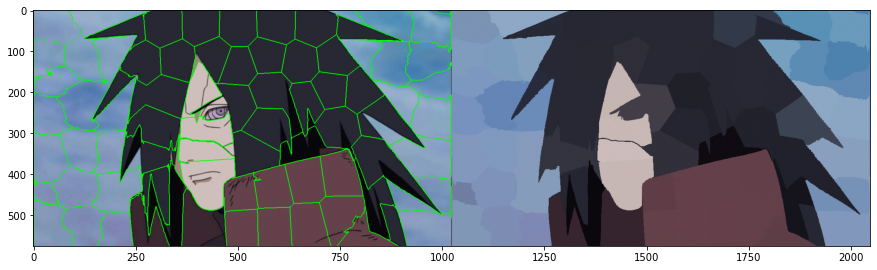

In [11]:
from skimage.segmentation import slic, mark_boundaries

img = imread('madara.jpg')
seg = slic(img, 100, 10, multichannel=True)
out = np.zeros_like(img)

for col in np.unique(seg):
    out[seg == col] = np.mean(img[seg == col], axis=0)

cols = np.unique(out.reshape(-1, 3), axis=0)

plt.figure(figsize=(15, 15))
final = np.hstack((mark_boundaries(img, seg, (0, 1, 0)), out/255.0))
plt.imshow(final)

plt.show()

# Morphological Operations
- Having done the segmentation and extraction of binary mask, usually the resultant image has some defects
- The defects include for example holes, noise
- Morph-operations help fix those defects by a way of convolving a structuring element over an image
- Most of Morphological operations are based on 2 primitive operations, namely `dilation` and `erosion`

# Dilation Operation $(A \oplus B)$
- Let $A$ be the image and $B$ be the kernel
- As the structuring element passes over the image, the center of the kernel is set to 1 if any of the pixels of the structuring element overlaps with the image
- It can be thought of as the bitwise OR Operation

# Erosion Operation $(A\ominus B)$
- Let $A$ be the image and $B$ be the kernel
- As the structuring element passes over the image, the center of the kernel is set to 1 if **ALL** of the pixels of the structuring element overlaps with the image, otherwise set to 0
- It can be thought of as the bitwise AND Operation

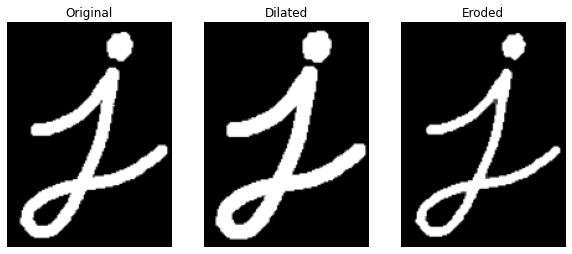

In [12]:
img = cv2.imread('morph.png', 0)

img = np.uint8(img)

dilated = cv2.dilate(img, np.ones((3, 3)), iterations=1)
eroded  = cv2.erode(img, np.ones((3, 3)), iterations=1)

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(132)
plt.title('Dilated')
plt.axis('off')
plt.imshow(dilated)

plt.subplot(133)
plt.title('Eroded')
plt.axis('off')
plt.imshow(eroded)

# Application of Morphological Operation

# Openning $A\circ B=(A \ominus B)\oplus B$
- An Image is eroded first then it is dilated
## The process in the image below is called "Morphological Filtering"

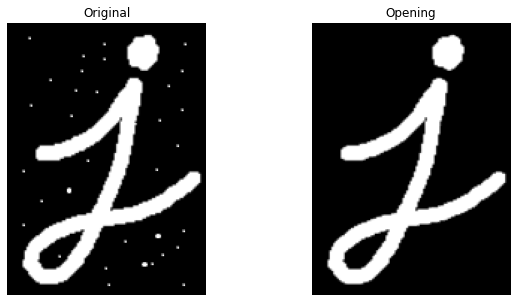

In [50]:
img = cv2.imread('dots.png', 0)

img = np.uint8(img)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opening  = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Opening')
plt.axis('off')
plt.imshow(opening)

# Closing $A \boldsymbol{\cdot} B=(A \oplus B)\ominus B$
- An Image is dilated first then it is eroded

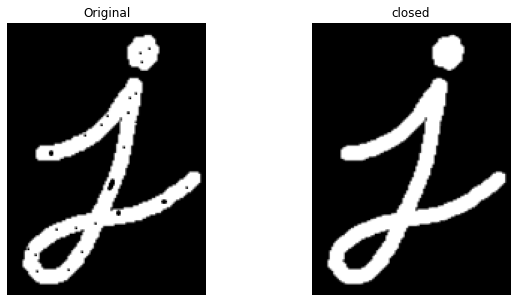

In [51]:
img = cv2.imread('close.png', 0)

img = np.uint8(img)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed  = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('closed')
plt.axis('off')
plt.imshow(opening)

## Openning can be used to separate objects connected by thin lines

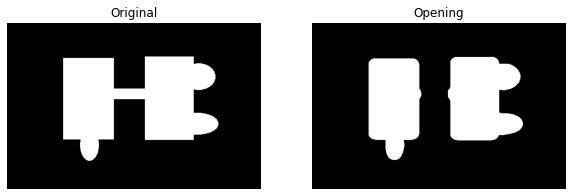

In [52]:
img = cv2.imread('open_sep.png', 0)

img = np.uint8(img)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
opening  = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title('Opening')
plt.axis('off')
plt.imshow(opening)

# Boundary Extraction Algorithm
- Boundaries can be extracted from an image by eroding an image by a $3*3$ kernel and subtracting the eroded image from the original
$$B=A-(A\ominus B)$$

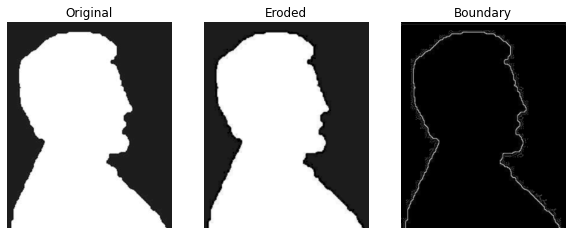

In [53]:
img = cv2.imread('boundary.png', 0)

img = np.uint8(img)

eroded  = cv2.erode(img, np.ones((3,3)), iterations=1)

out = cv2.bitwise_xor(img, eroded)



plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(132)
plt.title('Eroded')
plt.axis('off')
plt.imshow(eroded)

plt.subplot(133)
plt.title('Boundary')
plt.axis('off')
plt.imshow(out)

# Image Features
- There is no rigorous definition of what an image feature is
- Image features are all useful information that can be used to describe what is in the image

# Contours
- Contour is a curve that joins all the continuous points (along the boundary)
- Contours are a useful tool for shape analysis and object detection and recognition.

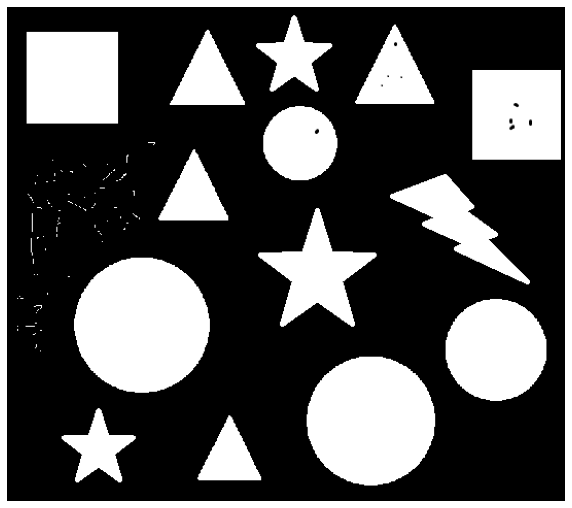

In [13]:
image = cv2.imread('c_edit.png')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image)

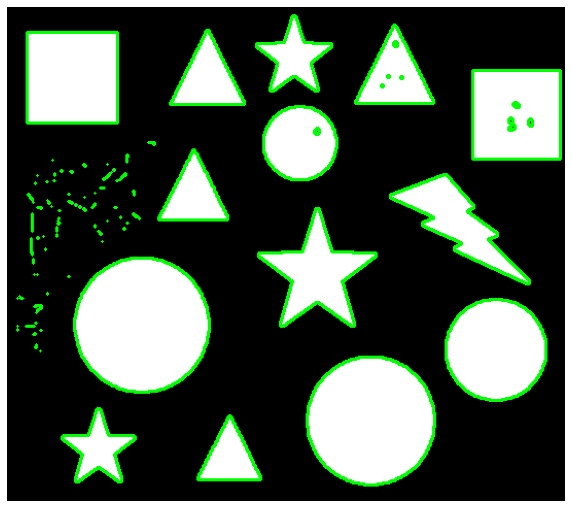

In [35]:
_, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
contours, h = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

draw_image = image.copy()
final = cv2.drawContours(draw_image, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(final)

# Contour Features
## Area
- Area can be used to specify a lower bound and an upper bound for regions of interest

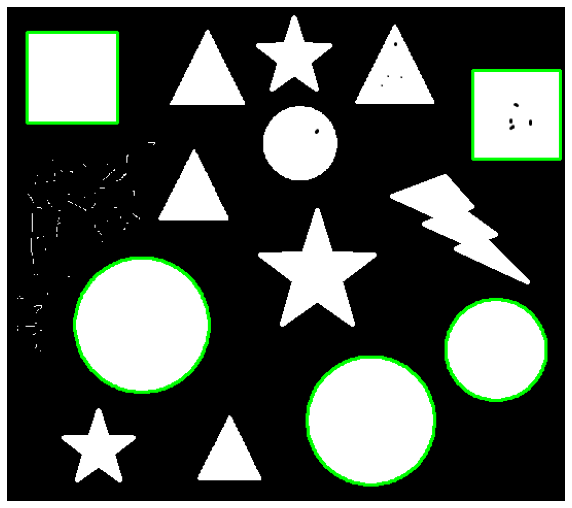

In [16]:
area_filtered_contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))

draw_image = image.copy()
final = cv2.drawContours(draw_image, area_filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(final)

## Convex Hull
- Convex hull of a collection of point is the minimum area convex polygon that encloses all points

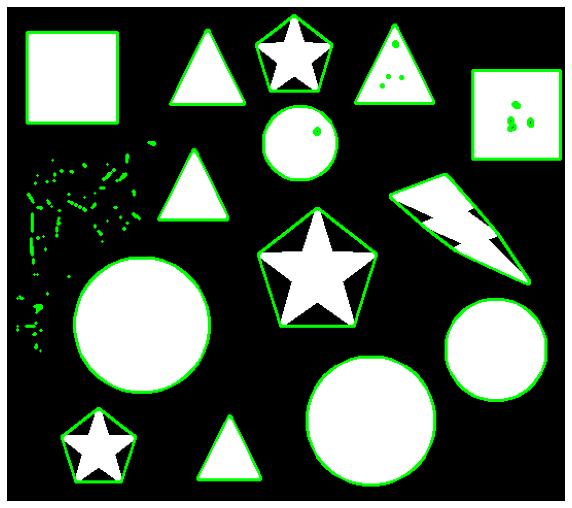

In [57]:
convexity_filtered_contours = list(map(lambda x: cv2.convexHull(x), contours))

draw_image = image.copy()
final = cv2.drawContours(draw_image, convexity_filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(final)

## Bounding Rectangle
- It is the minimum area rectangle that encloses a contour
- Its sides are always parallel to the image axes

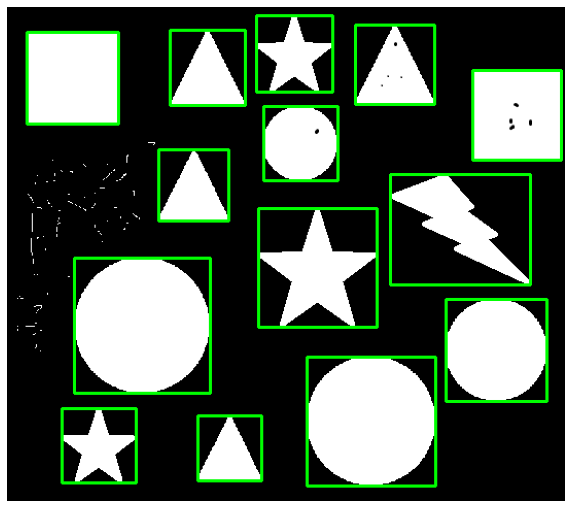

In [21]:
rectangles = list(map(lambda x: cv2.boundingRect(x), contours))

draw_image = image.copy()
for rect in rectangles:
    x, y, w, h = rect
    cv2.rectangle(draw_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#final = cv2.drawContours(draw_image, convexity_filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw_image)

## Minimum Area Rectangle
- it is a rotated rectangle that encloses the contour with minimum area

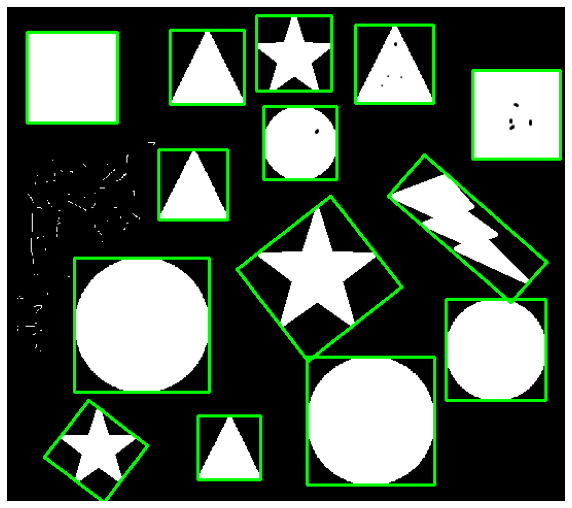

In [22]:
rectangles = list(map(lambda x: cv2.minAreaRect(x), contours))

draw_image = image.copy()
for rect in rectangles:
    points = np.int0(cv2.boxPoints(rect))
    cv2.drawContours(draw_image, [points], -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw_image)

## Minimum Area Circle, Ellipse, Triangle

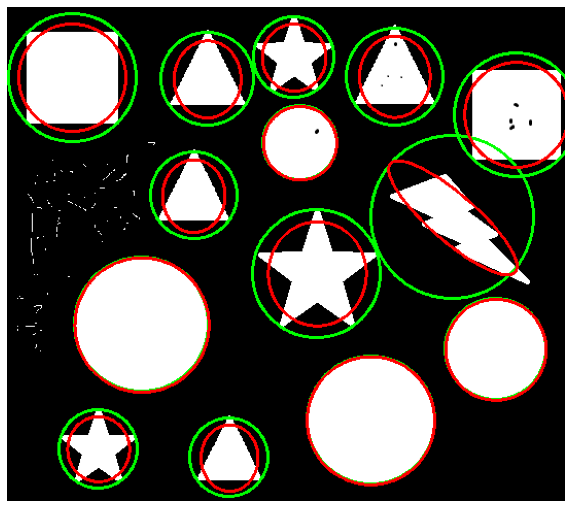

In [37]:
filtered_contours = list(filter(lambda x: cv2.contourArea(x)>1000, contours))

circles = list(map(lambda x: cv2.minEnclosingCircle(x), filtered_contours))
ellpises = list(map(lambda x: cv2.fitEllipse(x), filtered_contours))

draw_image = image.copy()
for circ, ellip in zip(circles, ellpises):
    (x, y), r = circ
    (x, y), (major_axis, minor_axis), angle = ellip
    
    cv2.circle(draw_image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.ellipse(draw_image, ellip, (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw_image)

# Hough Transform
- The Hough transform (HT) can be used to detect lines
- Hough transform can detect lines, circles and other structures `ONLY if` their parametric equation is known.
- It can give robust detection under noise

<img src="hough_rep.png" align="right" auto/>

# How it works
- The equation of line in 2D space is
$$y=m x +b$$
, where $(m,b)$ are parameters and $(x, y)$ are variable pixel locations
- This representation has a singularity when it represents a vertical line      ($m=\infty$)
- A better parameterization is to use the radius vector $\rho$ and the angle $\theta$
- Equation of line in polar cordinates is
$$\rho = x \cos{\theta}+y \sin{\theta}$$

# Hough Space
- The space of all posible lines is represented by a 2D matrix called the Hough space `H`
- Each entry represents a line parameterized by $(\rho, \theta)$ in the hough matrix by $H[\rho, \theta]$

# Algorithm
for every pixel $(x,y)$ in the image
- if the pixel is 0, skip
- if the pixel is 1:
    - for every $\theta$ increment its respective $H[\rho, \theta]$

After image traversal finishes, we can set a threshold for pixels to be considered a line

# Example

(600, 868, 3)
(5, 2)


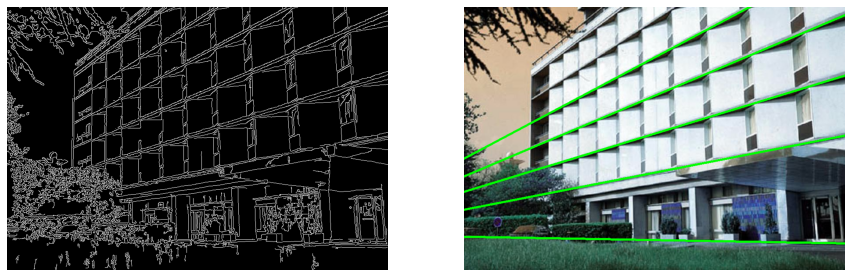

In [90]:
img = cv2.imread('building.jpg')
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 1)
edges = cv2.Canny(img,50,150,L2gradient=True)

lines = cv2.HoughLines(edges,1,np.pi/180,280)#, min_theta=81*np.pi/180, max_theta=97*np.pi/180)
lines = lines.reshape(lines.shape[0], -1)
print(lines.shape)
for rho,theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    img = cv2.line(img,(x1,y1),(x2,y2),(0,255,0),3)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(edges)
plt.axis('off')

plt.subplot(122)
plt.imshow(img)
plt.axis('off')
plt.show()

(480, 640, 3)
(1, 5, 3)
(5, 3)


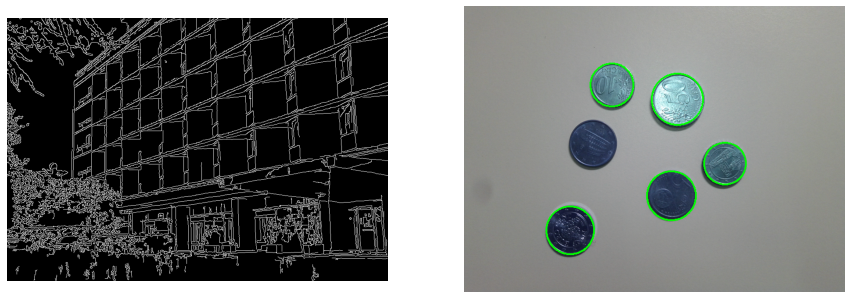

In [110]:
img = cv2.imread('coins.png')
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 1)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=10, minRadius=1, param1=100, param2=80)
# HoughCircles already does Canny edge detection internally. param1 is the higher threshold of canny, the samller is half the larger
# param2 is the threshold for considering circles
# dp -> inverse

circles = np.int32(np.around(circles))
print(circles.shape)
circles = circles.reshape(-1, 3)
print(circles.shape)
for x, y, r in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 2)

    img = cv2.line(img,(x1,y1),(x2,y2),(0,255,0),3)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(edges)
plt.axis('off')

plt.subplot(122)
plt.imshow(img)
plt.axis('off')
plt.show()

# Image Features
- Features have no universal definition
- It can be thought of as any distinctive features of an image